## Disease Prediction Using Classification

In this notebook, we build a classification model to **predict the disease (prognosis)** based on a patient's symptoms, weather conditions, and other features such as age and gender.

### 🔍 Why Classification?

This task is a classic **supervised learning problem**: we have input features and a known output label (`prognosis`). Classification allows us to train a model that can learn from historical cases and make accurate predictions on new patient data.

For example:
- If a patient presents with **headache, vomiting, and high temperature**, the model may predict a high probability of **Migraine**.
- If a patient has **chest pain, high blood pressure, and humidity is high**, it might predict **Heart Attack**.

These predictions could support **clinical decision-making**, early detection, or patient triage.

### 🔗 How Pattern Mining Helps

Earlier, we used pattern mining (FP-Growth) to identify frequent symptom combinations linked to specific diseases. Those patterns help:
- Highlight **strong symptom-disease associations** (e.g., `{headache, vomiting} → Migraine`)
- Guide **feature importance awareness** before modeling
- Validate whether the model is learning similar relationships

### ❌ Why Not Clustering or Outlier Detection?

- **Clustering** is unsupervised and used to explore hidden groupings — but we already know the disease labels.
- **Outlier detection** identifies rare or unusual data points — useful for anomaly detection, not disease prediction.

Therefore, **classification** is the most appropriate and effective approach for our goal.


## Step 1: Load Preprocessed Data

We begin by loading the cleaned and scaled dataset from the preprocessing step. This dataset includes both binary symptom indicators and continuous features (e.g., age, weather) that have been normalized.


In [7]:
import pandas as pd

# Load preprocessed data
df = pd.read_csv("../data/processed/cleaned_data.csv")

# Separate features and target
X = df.drop(columns=["prognosis"])
y = df["prognosis"]

print(f"Dataset shape: {X.shape}")
print(f"Target classes: {y.nunique()} → {y.unique()[:11]}")
# Display first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(X.head())


Dataset shape: (4981, 49)
Target classes: 11 → ['Heart Attack' 'Influenza' 'Dengue' 'Sinusitis' 'Eczema' 'Common Cold'
 'Heat Stroke' 'Migraine' 'Malaria' 'Arthritis' 'Stroke']

First few rows of the dataset:
        Age  Gender  Temperature (C)  Humidity  Wind Speed (km/h)  nausea  \
0  0.030303       1         0.729691  0.586755           0.264610       1   
1  0.545455       0         0.654889  0.364238           0.486594       0   
2  0.444444       0         0.515404  0.709272           0.136890       0   
3  0.050505       0         0.933323  0.380132           0.575202       1   
4  0.696970       0         0.593129  0.793377           0.572230       0   

   joint_pain  abdominal_pain  high_fever  chills  ...  sinus_headache  \
0           0               0           0       0  ...               0   
1           0               0           0       1  ...               0   
2           0               0           0       0  ...               0   
3           0               0   

## Step 2: Split Data into Training and Test Sets

To evaluate our classification model, we split the data into two parts:

- **Training set**: Used to train the model (80% of the data).
- **Test set**: Used to evaluate how well the model performs on unseen data (20%).

We use `train_test_split()` from `scikit-learn` with the following parameters:

- `X`: All the input features (symptoms, age, weather data, etc.).
- `y`: The target labels (i.e., the `prognosis` column — the disease to be predicted).
- `test_size=0.2`: Allocates 20% of the data for testing.
- `stratify=y`: Ensures that each class (disease) is proportionally represented in both train and test sets.
- `random_state=42`: Ensures reproducibility by fixing the random seed.

This gives us:

- `X_train`: Feature values for training.
- `X_test`: Feature values for testing.
- `y_train`: Target labels for training.
- `y_test`: Target labels for testing.


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## Step 3: Train a K-Nearest Neighbors (KNN) Classifier

We train a KNN model using `k = 5`, which means the prediction is based on the 5 closest neighbors in the training data. KNN is a distance-based method, so it's important that continuous features are properly scaled — which was done during preprocessing.

In [27]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict on test set
y_pred = knn.predict(X_test)


## Step 3.1: Evaluate Model Performance

We evaluate the KNN model using standard classification metrics:
- **Accuracy**: Overall correctness
- **Precision / Recall / F1-Score**: Per-class evaluation
- **Confusion Matrix**: Visual breakdown of true vs predicted labels


Accuracy: 0.9679
              precision    recall  f1-score   support

   Arthritis       1.00      0.98      0.99        60
 Common Cold       0.90      0.98      0.94        62
      Dengue       1.00      0.97      0.98        62
      Eczema       1.00      1.00      1.00        62
Heart Attack       0.98      0.98      0.98       194
 Heat Stroke       1.00      0.91      0.95        65
   Influenza       0.92      0.94      0.93       126
     Malaria       1.00      0.98      0.99        64
    Migraine       0.96      0.97      0.96       180
   Sinusitis       1.00      0.97      0.98        60
      Stroke       0.95      0.95      0.95        62

    accuracy                           0.97       997
   macro avg       0.97      0.97      0.97       997
weighted avg       0.97      0.97      0.97       997



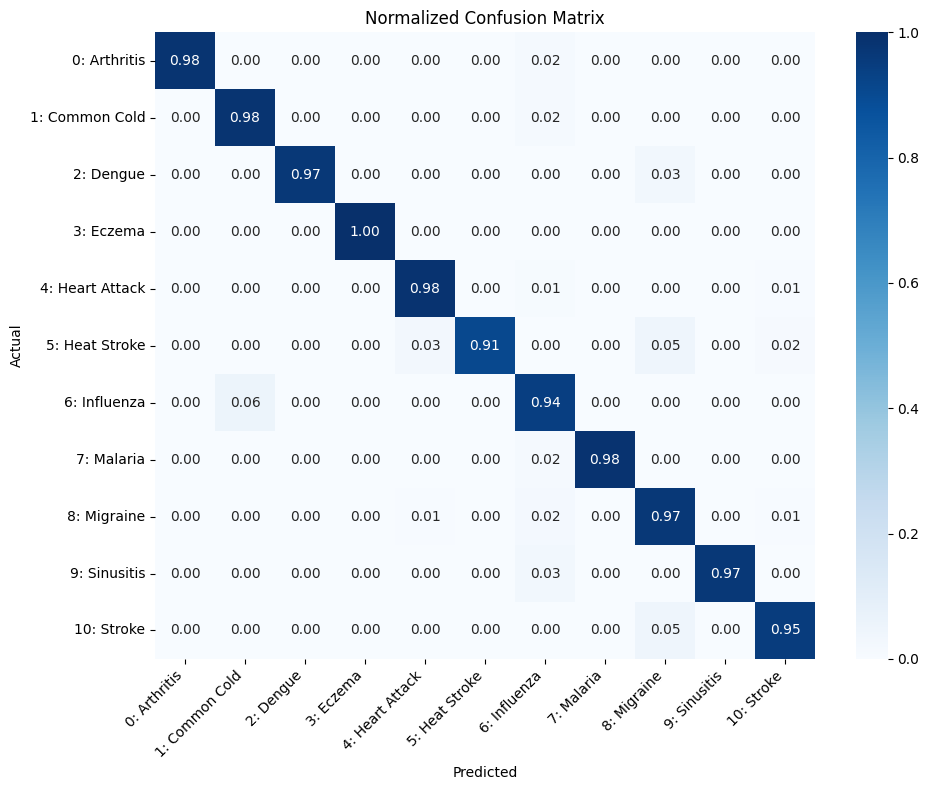

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Classification Report
print(classification_report(y_test, y_pred))

# Define class names
class_names = [
    "Arthritis", "Common Cold", "Dengue", "Eczema", "Heart Attack",
    "Heat Stroke", "Influenza", "Malaria", "Migraine", "Sinusitis", "Stroke"
]

# Format labels: 0: Arthritis, 1: Common Cold, etc.
labels = [f"{i}: {name}" for i, name in enumerate(class_names)]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize it
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Make sure the report folder exists
os.makedirs("../report", exist_ok=True)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Save
plt.savefig("../report/confusion_matrix_normalized.png", dpi=300)
plt.show()


## Step 3.2: Optimize the Number of Neighbors (k)

K-Nearest Neighbors relies on the `k` parameter — the number of nearest neighbors used to classify a new point.

Choosing the right `k` is crucial:
- **Too small** → very sensitive to noise (overfitting).
- **Too large** → overly smooth predictions (underfitting).

In this step, we evaluate multiple values of `k` and visualize their corresponding accuracy scores. Our goal is to select the value of `k` that maximizes accuracy on the test set.


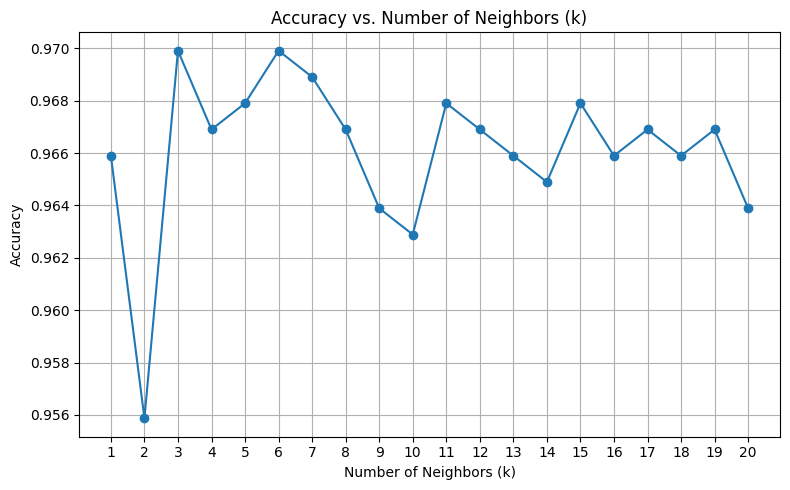

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

k_values = range(1, 21)
accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred_k = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred_k)
    accuracies.append(acc)

# Plot accuracy vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o')
plt.title("Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig("../report/knn_k_optimization.png", dpi=300)
plt.show()


## Step 3.3: Final KNN Model & Interpretation

After tuning the `k` value, we retrain the model using the **best-performing number of neighbors** and finalize our results.

We evaluate this model again to confirm its performance and summarize the key takeaways.


In [ ]:
# Final model with best k (replace with your chosen best_k)
best_k = k_values[accuracies.index(max(accuracies))]
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)
final_preds = final_knn.predict(X_test)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

print(f"✅ Final KNN model trained with k = {best_k}")
print("\nFinal Classification Report:")
print(classification_report(y_test, final_preds))




✅ Final KNN model trained with k = 3

Final Classification Report:
              precision    recall  f1-score   support

   Arthritis       1.00      0.98      0.99        60
 Common Cold       0.88      0.98      0.93        62
      Dengue       0.98      0.97      0.98        62
      Eczema       1.00      1.00      1.00        62
Heart Attack       0.99      0.99      0.99       194
 Heat Stroke       0.97      0.94      0.95        65
   Influenza       0.94      0.93      0.94       126
     Malaria       0.98      0.98      0.98        64
    Migraine       0.96      0.98      0.97       180
   Sinusitis       1.00      0.97      0.98        60
      Stroke       0.97      0.94      0.95        62

    accuracy                           0.97       997
   macro avg       0.97      0.97      0.97       997
weighted avg       0.97      0.97      0.97       997

